# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
 - /datasets/geo_data_0.csv. - 1-й регион
 - /datasets/geo_data_1.csv. - 2-й регион
 - /datasets/geo_data_2.csv. - 3-й регион
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей).

# Условия задачи:

 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
 
 
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Импортирую библиотеки и открываю файлы с данными

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучаю общую информацию о таблицах. Создам функцию, чтобы не повторять действия по изучению информации для каждого датасета.

In [3]:
def info(data):
    print(data.head(10))
    print()
    display(data.info())
    print()
    display(data.describe())
    print()
    plt.title('Корреляция между признаками', size = 12)
    sns.heatmap(data.corr(), annot = True)
    print()
    print('Количество уникальных значений')
    display(data.nunique())
    print()
    print('Количество явных дубликатов в таблице\n')
    display(data.duplicated().sum())    

Рассмотрю данные таблицы для первого региона.

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347




Количество уникальных значений


id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64


Количество явных дубликатов в таблице



0

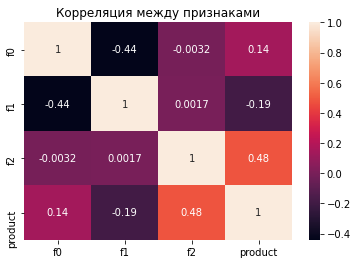

In [4]:
info(geo_data_0)

Рассмотрев таблицу, можно заметить, что типы данных указаны верно, в таблице отсутствуют пропуски, отсутствуют явные дубликаты, признак `f2` достаточно сильно коррелирует с целевым признаком `product`. Также в таблице наблюдается повторение десяти уникальных значений идентификаторов скважин, чего не должно быть. Узнать, с чем связано данное повторение не предоставляется возможным, поэтому удалю эти скважины, чтобы в дальнейшем не появлялась путаница, тем более, что это всего 0,01%.

In [5]:
geo_data_0 = geo_data_0.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
geo_data_0.nunique()

id         99980
f0         99980
f1         99980
f2         99980
product    99980
dtype: int64

Теперь рассмотрю данные таблицы для второго региона.

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408




Количество уникальных значений


id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64


Количество явных дубликатов в таблице



0

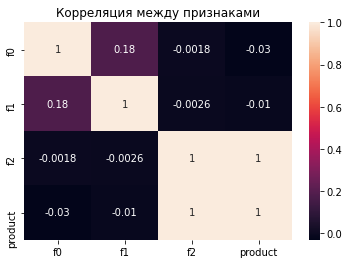

In [6]:
info(geo_data_1)

Данные во второй таблице тоже хорошо подготовлены. Типы данных соответствуют, отсутствуют пропуски, но снова повторяются уникальные иденификаторы скажин. Удалю дублирующиеся `id`. Так же можно заметить, что признак `f2` сильно коррелирует с целевым признаком `product`.

In [7]:
geo_data_1 = geo_data_1.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
geo_data_1.nunique()

id         99992
f0         99992
f1         99992
f2         99992
product       12
dtype: int64

Осталось рассмотреть таблицу третьего региона.

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838




Количество уникальных значений


id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64


Количество явных дубликатов в таблице



0

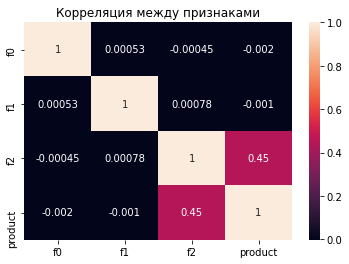

In [8]:
info(geo_data_2)

С третьей таблицей дела обстоят аналогично, как и с предыдущими. Таблица хорошо подготовлена, но повторяются уникальные идентификаторы скважен и признак `f2` коррелирует с целевым признаком `product`. Удалю дублирующиеся `id`.

In [9]:
geo_data_2 = geo_data_2.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
geo_data_2.nunique()

id         99992
f0         99992
f1         99992
f2         99992
product    99992
dtype: int64

**Вывод:**

 - Таблицы трех регионов хорошо подготовлены: типы данных соответствуют, отсутствуют пропуски, применен единый регистр, отсутствуют явные дубликаты;
 - Признак `f2` во всех регионах коррелирует с целевым признаком `product`;
 - В таблицах встречались дубликаты уникальных идентификаторов скважин. Дубликаты были удалены.

## Обучение и проверка модели

Создам функцию, которая обучит и проверит модели для разных регионов. Разделю таблицы на признаки и целевой признак, из признаков уберу колонку с `id`, она нам не понадобится. И разобью данные на обучающую и валидационную выборки в соотношении 75:25. Рассчитаю метрику RMSE для каждгого региона.

In [10]:
def model_validation(data):
    # разделяю данные на признаки и целевой признак
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    # отделияю 25% данных для валидационной выборки
    features_train, features_valid, target_train, target_valid = train_test_split(
                                                            features, target, test_size=0.25,
                                                            random_state=12345)
    # преобразовываю масштаб признаков методом стандартизации
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid) 
    # инициализирую и обучаю модель линейной регрессии,получаю предсказания модели на валидационной выборке 
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predictions_valid = pd.Series(predictions_valid)
    predictions_valid.index = target_valid.index
    # считаю значение метрики RMSE на валидационной выборке
    rmse = mean_squared_error(target_valid, predictions_valid, squared=False) 
    # возвращаю предсказания, правильные ответы и RMSE
    return predictions_valid, target_valid, rmse

Теперь рассчитаю средний запас предсказанного сырья и RMSE для первого региона.

In [11]:
predictions_valid_0, target_valid_0, rmse_0 = model_validation(geo_data_0)
print(f'Средний запас предсказанного сырья {predictions_valid_0.mean():.2f}  (тыс. баррелей)\nRMSE: {rmse_0}')

Средний запас предсказанного сырья 92.42  (тыс. баррелей)
RMSE: 37.716904960382735


Далее рассчитаю средний запас предсказанного сырья и RMSE для второго региона.

In [12]:
predictions_valid_1, target_valid_1, rmse_1 = model_validation(geo_data_1)
print(f'Средний запас предсказанного сырья {predictions_valid_1.mean():.2f}  (тыс. баррелей)\nRMSE: {rmse_1}')

Средний запас предсказанного сырья 68.98  (тыс. баррелей)
RMSE: 0.891490139034854


И осталось рассмотреть средний запас предсказанного сырья и RMSE для третьего региона.

In [13]:
predictions_valid_2, target_valid_2, rmse_2 = model_validation(geo_data_2)
print(f'Средний запас предсказанного сырья {predictions_valid_2.mean():.2f}  (тыс. баррелей)\nRMSE: {rmse_2}')

Средний запас предсказанного сырья 95.12  (тыс. баррелей)
RMSE: 39.975543264382345


Выведу полученные данные в отдельную таблицу.

In [14]:
frame = {
    'region': [1, 2, 3],
    'predictions': [predictions_valid_0.mean(), predictions_valid_1.mean(), predictions_valid_2.mean()],
           'rmse': [rmse_0, rmse_1, rmse_2]
           }

In [15]:
pd.DataFrame(frame)

,region,predictions,rmse
0,1,92.423841,37.716905
1,2,68.983119,0.891490
2,3,95.116223,39.975543


**Вывод:**

Глядя на результаты, можно заметить, что в первом и третьем регионах наибольшее количество среднего запаса предсказанного сырья - 92,42 и 95,12 тыс.баррелей, во втором регионе запасов значительно меньше - 68,98 тыс.баррелей. Но модель логистической регрессии лучше работает со вторым регионом, в данном регионе RMSE = 0,89, в отличие от первого и третьего регионов, где RMSE выше 37. Думаю RMSE во втором регионе связано с высокой корреляцией признака `f2` с целевым признаком и количеством уникальных значений в колонке `product`, которое составляет 12.

## Подготовка к расчёту прибыли

Учитывая условия задачи, для расчётов сохраню в отдельных переменных все ключевые значения и рассчитаю достаточный объём сырья для безубыточной разработки новой скважины.

In [16]:
BUDGET = 10e9
REVENUE_PER_BARREL = 450_000
STUDY_WELL = 500
BEST_STUDY_POINTS = 200
LOSS_PROBA = 0.025

In [17]:
need_barrel = BUDGET/REVENUE_PER_BARREL/BEST_STUDY_POINTS
min_income_well = BUDGET/BEST_STUDY_POINTS/10e5
print(f'''Достаточный объём сырья для безубыточной разработки новой скважины составляет {need_barrel:.2f} (тыс. баррелей)
Достаточный доход для безубыточности разработки новой скважины составляет {min_income_well:.0f} млн.рублей''')

Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.11 (тыс. баррелей)
Достаточный доход для безубыточности разработки новой скважины составляет 50 млн.рублей


Минимальный достаточный объем сырья для безубыточной разработки новой скважины выше, чем средний запас предсказанного сырья в каждом регионе. Необходимый объем для безубыточности 111,11 тыс.баррелей, а 92,42, 68,98, 95,11 тыс. баррелей средний запас сырья в первом, втором и третьем регионах соответственно. 
Необходимо найти скважины с запасом сырья больше среднего значения.

Теперь напишу функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели для 200 лучших точек и посчитаю прибыль для каждого региона.

In [19]:
def profit(target, predicted, count):
    top_well = predicted.sort_values(ascending=False)
    selected = target[top_well.index][:count]
    result = selected.sum()*REVENUE_PER_BARREL-BUDGET
    return result

In [ ]:
print(f'''Прибыль в первом регионе {profit(target_valid_0, predictions_valid_0, BEST_STUDY_POINTS)/10e8:.2f} млрд.руб.
Прибыль во втором регионе {profit(target_valid_1, predictions_valid_1, BEST_STUDY_POINTS)/10e8:.2f} млрд.руб.
Прибыль в третьем регионе {profit(target_valid_2, predictions_valid_2, BEST_STUDY_POINTS)/10e8:.2f} млрд.руб.''')

**Вывод:**
 Средний запас предсказанного сырья в каждом регионе ниже минимального объема сырья для достижения безубыточности. Отобраны 200 лучших точек со скважинами для разработки сырья и расчитана прибыль для полученного объема в каждом регионе. Максимальная прибыль в первом регионе и составляет 3,14 млрд. рублей.

## Расчёт прибыли и рисков 

Теперь посчитаю риски и прибыль для каждого региона с применением техники Bootstrap с 1000 выборками. Найду среднюю прибыль, 95%-й доверительный интервал и риск убытков.

Для начала напишу функцию для расчета данных для каждого региона.

In [21]:
state = np.random.RandomState(12345)
def distribution_profit(target, probabilities):
    values = []
    # применяю бутстреп 1000 раз 
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        result = profit(target_subsample, probs_subsample, BEST_STUDY_POINTS)
        values.append(result)
    # рассчитываю среднюю прибыль
    values = pd.Series(values)
    mean = values.mean()/10e5
    # нахожу 95%-й доверительный интервал
    lower = values.quantile(q=0.025)/10e5
    upper = values.quantile(q=0.975)/10e5
    # определяю риск убытков
    risk = (values < 0).mean()*100


    print(f'''Средняя прибыль {mean:.2f} млн.руб.
95%-й доверительный интервал {lower:.2f} - {upper:.2f} млн.руб.
Риск убытков {risk:.2f}%''')

**Регион 1**

In [22]:
distribution_profit(target_valid_0, predictions_valid_0)

Средняя прибыль 459.09 млн.руб.
95%-й доверительный интервал -90.23 - 987.95 млн.руб.
Риск убытков 4.70%


**Регион 2**

In [23]:
distribution_profit(target_valid_1, predictions_valid_1)

Средняя прибыль 523.58 млн.руб.
95%-й доверительный интервал 133.79 - 961.45 млн.руб.
Риск убытков 0.60%


**Регион 3**

In [24]:
distribution_profit(target_valid_2, predictions_valid_2)

Средняя прибыль 341.47 млн.руб.
95%-й доверительный интервал -198.36 - 852.71 млн.руб.
Риск убытков 11.60%


**Вывод:**

Рассчитана средняя прибыль, доверительный интервал и риски. Лучшие показатели у региона 2, данный регион единственный у которого вероятность убытка меньше 2,5%. 


## Общий вывод

В ходе выполнения проекта получены следующие результаты:

 - Обученные модели линейной регрессии показали, что минимальная RMSE соответствует 2-му региону и составляет 0,89, в отличие от 1-го и 3-го регионов, где RMSE выше 37. А наибольший предсказанный средний запас сырья в 1-м и 3-м регионах.
 - Отобраны скважины с максимальным количеством предсказаний и рассчитайте прибыль для полученного объёма сырья. Максимальная прибыль в первом регионе и составляет 3,14 млрд. рублей.
 - Рассчитана средняя прибыль, 95%-й доверительный интервал и оценка риска. После оценки рисков выявлено, что условию задачи соответствует регион 2 - вероятность убытков составляет меньше 2,5% и данный регион имеет наибольшую среднюю прибыль. 
 
**Рекомендация**
 
 Для разработки новых скважин рекомендуется регион 2, т.к. в данном регион наименьшая вероятность убытков 0,6% и максимальная средняя прибыль.